In [519]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

import xgboost

import pickle

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import ClusterCentroids 
from imblearn.under_sampling import CondensedNearestNeighbour 
from imblearn.over_sampling import RandomOverSampler 
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SVMSMOTE

import traceback
import optuna

# 1. Baseline model

In [580]:
#reading the dataframe
df = pd.read_csv('term-deposit-marketing-2020.csv')

#ordering the dataframe using the natural order of months
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec']
df.month = df.month.astype('category')
df.month.cat.set_categories(months, ordered=True, inplace=True)
df.sort_values(by='month', ascending=True, inplace=True)

#converting objects and categories into numerical dtype
for cat in [col for col in df.columns if df[col].dtype == 'O' or 'category']:
    le = LabelEncoder()
    df[cat] = le.fit_transform(df[cat].values)

X = df.iloc[:, range(0,13)]
y = df.iloc[:, 13]

In [581]:
xgb = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42)
scores = cross_val_score(xgb, X, y, cv=5, scoring='f1_macro')
scores.mean()

0.5408001785359933

# 2. Feature Engineering

In [548]:
#reading the dataframe
df = pd.read_csv('term-deposit-marketing-2020.csv')

#ordering the dataframe using the natural order of months
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec']
df.month = df.month.astype('category')
df.month.cat.set_categories(months, ordered=True, inplace=True)
df.sort_values(by='month', ascending=True, inplace=True)

#converting objects and categories into numerical dtype
for cat in [col for col in df.columns if df[col].dtype == 'O' or 'category']:
    le = LabelEncoder()
    df[cat] = le.fit_transform(df[cat].values)

df = pd.concat([df,df.pop('y')],1)

#normalizing the data
standard_scaler = StandardScaler()
df['duration'] = standard_scaler.fit_transform(df[['duration']])
df['balance'] = standard_scaler.fit_transform(df[['balance']])
df['age'] = standard_scaler.fit_transform(df[['age']])
df['day'] = standard_scaler.fit_transform(df[['day']])
df['month'] = standard_scaler.fit_transform(df[['month']])

X = df.iloc[:, range(0,13)]
y = df.iloc[:, 13]

### Baseline model with normalized features

In [549]:
xgb = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42)
scores = cross_val_score(xgb, X, y, cv=5, scoring='f1_macro')
scores.mean()

0.5405108534415807

Normalization hasn't made any difference to the baseline model

# 3. Imbalanced Learn - Iterator

Building an iterator to identify the ideal imblearn resamplers that has the highest accuracy. 

Note: accuracy is defined here using F1-macro because it treats both classes equally i.e. no preferential weighting towards majority class, and thus we are able to assess the overall model performance when it comes to classification

In [550]:
undersampler_models = [RandomUnderSampler, NearMiss, TomekLinks, EditedNearestNeighbours, 
                       RepeatedEditedNearestNeighbours, AllKNN, OneSidedSelection, NeighbourhoodCleaningRule]
oversampler_models = [RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE]

xgb = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42)

def undersampling_model (X, y, undersampler):
    pipe = make_pipeline(undersampler(), xgb)
    scores = cross_val_score(pipe, X, y, cv=5, scoring='f1_macro')
    return scores.mean()

print("Undersampling:")
for under_idx, undersampler in enumerate(undersampler_models):
    try:
        print(undersampler_models[under_idx].__name__, undersampling_model(X,y,undersampler))
    except Exception:
        traceback.print_exc()

def oversampling_model (X, y, oversampler):
    pipe = make_pipeline(oversampler(), xgb)
    scores = cross_val_score(pipe, X, y, cv=5, scoring='f1_macro')
    return scores.mean()

print("Oversampling:")
for over_idx, oversampler in enumerate(oversampler_models):
    try:
        print(oversampler_models[over_idx].__name__, oversampling_model(X,y,oversampler))
    except Exception:
        traceback.print_exc()

def under_over_model (X, y, undersampler, oversampler):
    pipe = make_pipeline(undersampler(), oversampler(), xgb)
    scores = cross_val_score(pipe, X, y, cv=5, scoring='f1_macro')
    return scores.mean()


print("Undersampling and Oversampling:")
for under_idx, undersampler in enumerate(undersampler_models):
    for over_idx, oversampler in enumerate(oversampler_models):
        try:
            print(undersampler_models[under_idx].__name__, oversampler_models[over_idx].__name__, 
              under_over_model(X,y,undersampler,oversampler))
        except Exception:
            traceback.print_exc()

Undersampling:
RandomUnderSampler 0.5197891512010179
NearMiss 0.3049603852848022
TomekLinks 0.5501962904296305
EditedNearestNeighbours 0.5681079415030997
RepeatedEditedNearestNeighbours 0.5890109348685011
AllKNN 0.5836931533706562
OneSidedSelection 0.5407643096260495
NeighbourhoodCleaningRule 0.5625949325551176
Oversampling:
RandomOverSampler 0.5192152126788825
SMOTE 0.5329887438153773
ADASYN 0.5193192898168223
BorderlineSMOTE 0.5312615948988106
SVMSMOTE 0.5345009159647465
Undersampling and Oversampling:
RandomUnderSampler RandomOverSampler 0.5212292082319163
RandomUnderSampler SMOTE 0.522747004356469
RandomUnderSampler ADASYN 0.5198335759261756
RandomUnderSampler BorderlineSMOTE 0.5290307022904323
RandomUnderSampler SVMSMOTE 0.526929951619959
NearMiss RandomOverSampler 0.3049603852848022
NearMiss SMOTE 0.3049603852848022
NearMiss ADASYN 0.3049603852848022
NearMiss BorderlineSMOTE 0.3049603852848022
NearMiss SVMSMOTE 0.3049603852848022
TomekLinks RandomOverSampler 0.5339974403676238
To

In [551]:
xgb = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42)

for n_neighbor in range(1,7):
    for kind_sel in ['mode', 'all']:
        pipe = make_pipeline(RepeatedEditedNearestNeighbours(n_neighbors=n_neighbor, kind_sel=kind_sel), xgb)
        scores = cross_val_score(pipe, X, y, cv=5, scoring='f1_macro')
        print('Undersampler N-neighbor: {0}, Undersampler kind_sel: {1}, Cross Validation Score: {2}' .format(n_neighbor, kind_sel, scores.mean()))

Undersampler N-neighbor: 1, Undersampler kind_sel: mode, Cross Validation Score: 0.55285211375872
Undersampler N-neighbor: 1, Undersampler kind_sel: all, Cross Validation Score: 0.55285211375872
Undersampler N-neighbor: 2, Undersampler kind_sel: mode, Cross Validation Score: 0.5391570104270793
Undersampler N-neighbor: 2, Undersampler kind_sel: all, Cross Validation Score: 0.5697661237647393
Undersampler N-neighbor: 3, Undersampler kind_sel: mode, Cross Validation Score: 0.5575514077096534
Undersampler N-neighbor: 3, Undersampler kind_sel: all, Cross Validation Score: 0.5890109348685011
Undersampler N-neighbor: 4, Undersampler kind_sel: mode, Cross Validation Score: 0.5507201332452022
Undersampler N-neighbor: 4, Undersampler kind_sel: all, Cross Validation Score: 0.58432055924886
Undersampler N-neighbor: 5, Undersampler kind_sel: mode, Cross Validation Score: 0.5668185925848768
Undersampler N-neighbor: 5, Undersampler kind_sel: all, Cross Validation Score: 0.5988627224940621
Undersample

#### Hyperparameter Tuning

In [ ]:
def objective(trial, X, y):
    params = {
        "eta": trial.suggest_float("eta", 0.01, 0.1),
        "gamma": trial.suggest_float("gamma", 0.05, 1, step=0.05),
        "max_depth": trial.suggest_int("max_depth", 3, 25),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0, step=0.1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0, step=0.1),
        "lambda": trial.suggest_float("lambda", 0.1, 1.0, step=0.1),
        "alpha": trial.suggest_float("alpha", 0.1, 1.0, step=0.1),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 3, step=0.5),
        "n_estimators": trial.suggest_int("n_estimators", 1, 30, step=1),
        "random_state": 42
    }
    xgb = xgboost.XGBClassifier(**params, use_label_encoder=False, eval_metric='auc')
    pipe = make_pipeline(RepeatedEditedNearestNeighbours(n_neighbors=5, kind_sel='all'), xgb)
    scores = cross_val_score(pipe, X, y, cv=5, scoring='f1_macro')
    return scores.mean()

# Create study that minimizes
study = optuna.create_study(direction="maximize")

# Pass additional arguments inside another function
func = lambda trial: objective(trial, X, y)

# Start optimizing with 100 trials
study.optimize(func, n_trials=200)

In [557]:
study.optimize(func, n_trials=5)

[I 2021-12-21 07:32:27,488] Trial 88 finished with value: 0.560853808368471 and parameters: {'eta': 0.030149735585085373, 'gamma': 0.7500000000000001, 'max_depth': 15, 'min_child_weight': 8, 'subsample': 0.8, 'colsample_bytree': 0.4, 'lambda': 0.7000000000000001, 'alpha': 1.0, 'scale_pos_weight': 1, 'n_estimators': 16}. Best is trial 51 with value: 0.7159407661174922.
[I 2021-12-21 07:36:44,949] Trial 89 finished with value: 0.6278696993321065 and parameters: {'eta': 0.0566876788479315, 'gamma': 0.8, 'max_depth': 18, 'min_child_weight': 6, 'subsample': 0.9, 'colsample_bytree': 0.5, 'lambda': 0.8, 'alpha': 0.5, 'scale_pos_weight': 1, 'n_estimators': 22}. Best is trial 51 with value: 0.7159407661174922.
[I 2021-12-21 07:40:23,783] Trial 90 finished with value: 0.48122016981071936 and parameters: {'eta': 0.03927130749333967, 'gamma': 0.9500000000000001, 'max_depth': 23, 'min_child_weight': 10, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.1, 'lambda': 0.8, 'alpha': 0.700000000000

In [558]:
study.best_params

{'eta': 0.05885398645111972,
 'gamma': 0.9000000000000001,
 'max_depth': 20,
 'min_child_weight': 4,
 'subsample': 0.8,
 'colsample_bytree': 0.5,
 'lambda': 0.9,
 'alpha': 1.0,
 'scale_pos_weight': 1,
 'n_estimators': 1}


# 4. Final Model

In [559]:
#optimized xgboost hyperparmater with imblearn pipeline 
xgb = xgboost.XGBClassifier(eta=0.059, gamma=0.9, max_depth=20, min_child_weight=4, 
                            scale_pos_weight=1, subsample=0.8, colsample_bytree=0.5, reg_lambda=0.9, 
                            reg_alpha=1.0, n_estimators=1, use_label_encoder=False, 
                            eval_metric='auc', random_state=42)
pipe = make_pipeline(RepeatedEditedNearestNeighbours(n_neighbors=5, kind_sel='all'), xgb)
scores = cross_val_score(pipe, X, y, cv=5, scoring='f1_macro')
scores.mean()

0.7159407661174922

In [560]:
#saving the model
pickle.dump(xgb, open(('models/xgb_tuned.pkl'), 'wb'))

Using imblearn and hyperparamter tuning, we have improved the model performance from 0.54 to 0.72

# 5. Shap analysis

In [567]:
#hide input
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eta=0.059, eval_metric='auc', gamma=0.9,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.0590000004, max_delta_step=0, max_depth=20,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=1, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=1.0, reg_lambda=0.9,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


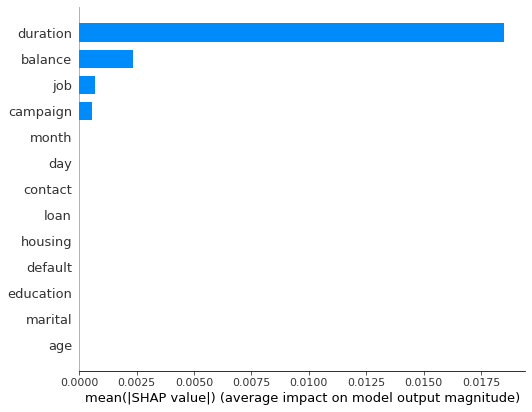

In [568]:
import shap
explainerXGB = shap.TreeExplainer(xgb)
shap_values_XGB_test = explainerXGB.shap_values(X_train)
shap.summary_plot(shap_values_XGB_test, X_train, plot_type='bar')

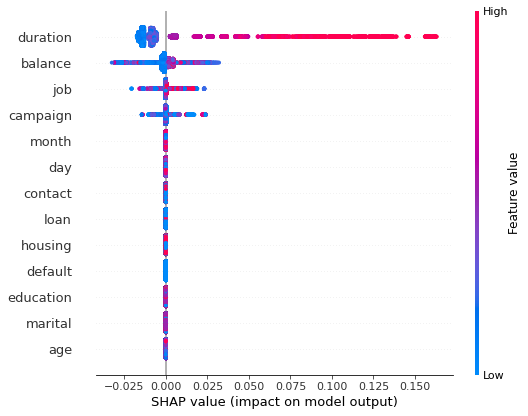

In [569]:
shap.summary_plot(shap_values_XGB_test, X_train)

Duration has the biggest impact on the model, which is probably because longer the duration of an interaction, the customer is more informed about the product and its benefits, thus allowing them to make a confident purchasing decision.

Balance, job and campaign seems to influence the model outcome more or less equally

Everyother feature does not seem to have any influence in the model behaviour, which suggests we could potentially class them as irrelevant to the given task

We can also look at the dependence plots (see below), keeping in mind that the vertical dispersion of the data points represent interaction effects.

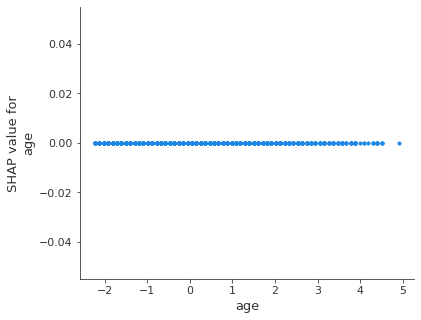

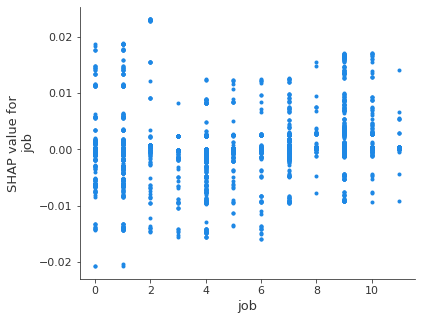

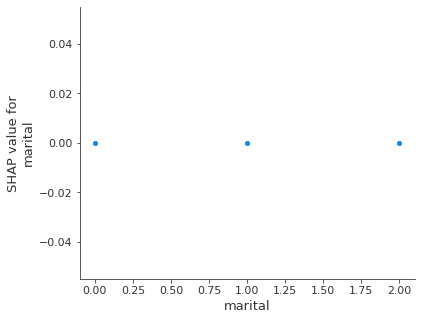

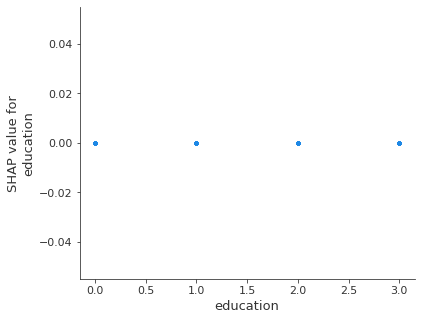

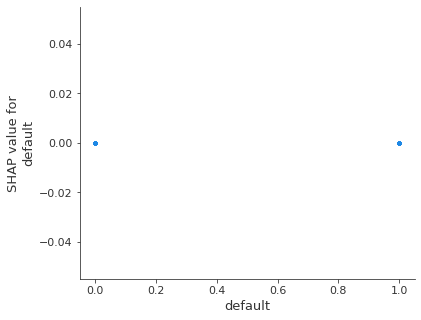

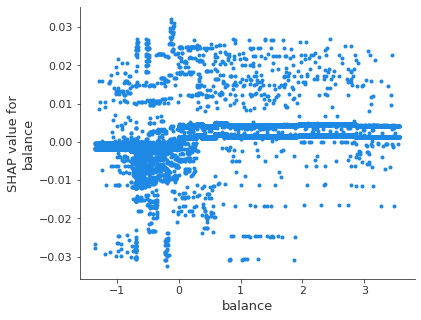

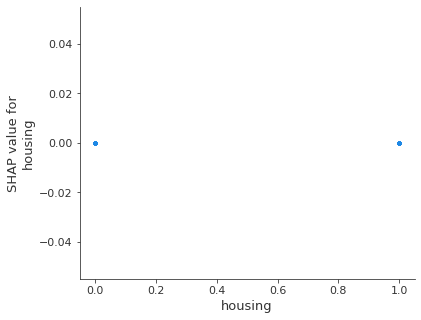

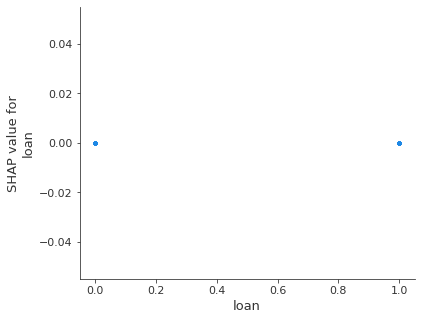

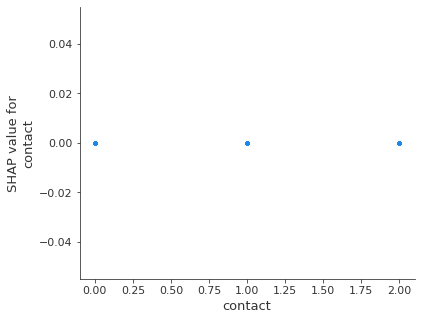

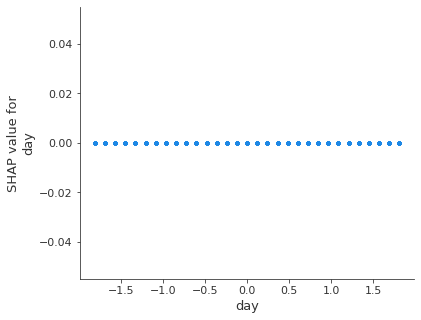

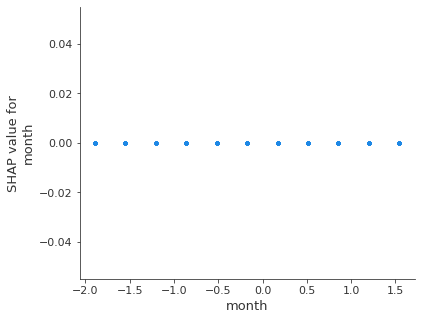

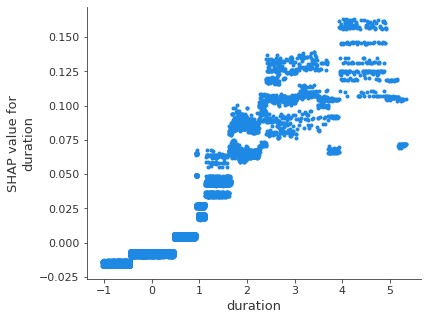

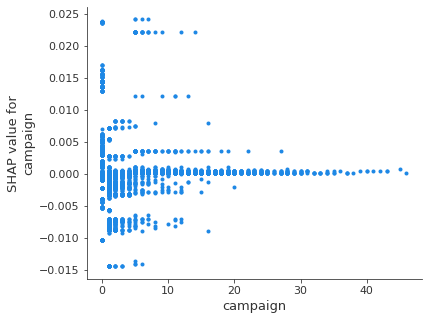

In [571]:
for name in X_test.columns:
    shap.dependence_plot(name, shap_values_XGB_test, X_train, interaction_index=None)

There is a linear relationship of some sort between model outcome and duration, which is consistent with what we have noticed earlier in SHAP summary plots.

# Removing all the features except duration, balance, campaign and job

In [578]:
#reading the dataframe
df = pd.read_csv('term-deposit-marketing-2020.csv')

#ordering the dataframe using the natural order of months
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec']
df.month = df.month.astype('category')
df.month.cat.set_categories(months, ordered=True, inplace=True)
df.sort_values(by='month', ascending=True, inplace=True)

for cat in [col for col in df.columns if col not in ['duration', 'balance', 'campaign', 'job', 'y']]:
    df.drop(cat, axis=1, inplace=True)

#converting objects and categories into numerical dtype
for cat in [col for col in df.columns if df[col].dtype == 'O' or 'category']:
    le = LabelEncoder()
    df[cat] = le.fit_transform(df[cat].values)

df = pd.concat([df,df.pop('y')],1)

#normalizing the data
standard_scaler = StandardScaler()
df['duration'] = standard_scaler.fit_transform(df[['duration']])
df['balance'] = standard_scaler.fit_transform(df[['balance']])

X = df.iloc[:, range(0,4)]
y = df.iloc[:, 4]

In [579]:
#optimized xgboost hyperparmater with imblearn pipeline 
xgb = xgboost.XGBClassifier(eta=0.059, gamma=0.9, max_depth=20, min_child_weight=4, 
                            scale_pos_weight=1, subsample=0.8, colsample_bytree=0.5, reg_lambda=0.9, 
                            reg_alpha=1.0, n_estimators=1, use_label_encoder=False, 
                            eval_metric='auc', random_state=42)
pipe = make_pipeline(RepeatedEditedNearestNeighbours(n_neighbors=5, kind_sel='all'), xgb)
scores = cross_val_score(pipe, X, y, cv=5, scoring='f1_macro')
scores.mean()

0.7098719680688687

Model accuracy (F1 score) had negligble difference with 9 less features 

# 6.Next steps

There is room to improve the model, but it would mean collecting more data including adding new features such as product and campaign information, and customer transactional records including both income and expenses. It might also be worth investigating and incorporating features that represent market sentiment as financially savvy customers are going to take that into account when making decision to purchase a term deposit.